TODO:
* znaleźć takie cząsteczki, dla których wszystkie metody miały MCC=0 (lub mniejsze niż jakiś próg). Potraktować je jako outliers.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!ls /data/2d-rna/validation-all-non0/results.rpt

/data/2d-rna/validation-all-non0/results.rpt


In [3]:
! ls /data/2d-rna

1.txt		 diff.py		    SPOT-RNA2_features
2d-rna-analysis  fasta1000		    SPOT-RNA2_outputs
2.txt		 fasta500		    test
7z2107		 fasta600		    tmp
all		 fasta600-1800		    to_remove.txt
all500.fasta	 fasta-cifs		    u-cifs
all.txt		 ipknot			    validation-all
a.txt		 predictions-bpseqs	    validation-all-non0
bar-all.png	 predictions-raw	    validation-canon
box-all.png	 predictions-rna-structure  validation-canon-non0
b.txt		 pseudoknots-bpseqs	    validation-noncanon
canon.txt	 remover.sh		    validation-noncanon-non0
cifs		 rnapdbee-cifs		    validation-pseudoknots
cifs-awk	 rna-structure-bpseqs	    validation-results
cifs-mini	 rna-struct-validation	    violin-all.png
clean-non0.sh	 seq500
dbn-cifs	 SPOT-RNA2


## Load results

In [4]:
res_path = "/data/2d-rna/validation-all-non0/results.rpt"
out_path = "all"

In [5]:
import os

def get_results(out_path, res_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    with open(res_path) as f:
        results = f.readlines()
    print(len(results))
    return results

res_all = get_results('all', "/data/2d-rna/validation-all-non0/results.rpt")
res_wc = get_results('canon', "/data/2d-rna/validation-canon-non0/results.rpt")
res_nwc = get_results('noncanon', "/data/2d-rna/validation-noncanon-non0/results.rpt")
res_pk = get_results('pseudoknots', "/data/2d-rna/validation-pseudoknots/results.rpt")

122716
119898
113502
49964


` :/data/2d-rna/cifs$ ls | sed 's/.cif//g' | awk '{ print toupper($0) }' | sort | uniq | wc -l`<br>
`12728` tyle jest unikalnych nazw w cząsteczek ignorując wielkoś znaków

`11733` tyle jest rekordów dla narzędzi w pliku wynikowym. Brakujące mogą wynikać z niezgodności sekwencji. <br>
TODO: 
Z pipeline usunąc "^^" i puścić jeszcze raz (toupper). Nazwy plików są poprawne.

### Filter results

Common subset

In [6]:
def get_subset_ids(results):
    subset_ids = {}
    k=""
    counter = 0
    for l in results:
        l = l.split()
        if len(l) == 0:
            break
        elif len(l) ==1:
            k=l[0]
        elif l[0]!="Tool":
            method = l[0]
            res = l[1:]
            res = [float(r) for r in res]
            if method not in subset_ids:
                subset_ids[method]=[]
            subset_ids[method].append(k)
        counter += 1
    print(counter)
    return subset_ids

all_ids = get_subset_ids(res_all)
wc_ids = get_subset_ids(res_wc)
nwc_ids = get_subset_ids(res_nwc)
pk_ids = get_subset_ids(res_pk)



122715
119897
113501
49963


In [7]:
list(all_ids.keys())

['contextFold',
 'contrafold',
 'e2efold',
 'mxfold',
 'mxfold2',
 'rna-state-inf',
 'spot-rna',
 'ipknot',
 'rnafold',
 'rna-structure',
 'ufold']

In [8]:
def filter_common(subset_ids):
    sets = []
    for m in list(subset_ids.keys()):
    # for m in ['mxfold', 'rnafold', 'spot-rna', 'mxfold2']:
    # for m in ['spot-rna', 'ufold', 'ipknot', 'e2efold']:
        print(m, len(subset_ids[m]))
        sets.append(set(subset_ids[m]))
    common = sets[0].intersection(*sets)
    print(len(common))
    print(sorted(common)[:10])
    return common
common_all = filter_common(all_ids)
common_wc = filter_common(wc_ids)
common_nwc = filter_common(nwc_ids)
common_pk = filter_common(pk_ids)


contextFold 10354
contrafold 10491
e2efold 9257
mxfold 10491
mxfold2 9374
rna-state-inf 10491
spot-rna 7671
ipknot 7665
rnafold 10491
rna-structure 7805
ufold 7643
7354
['100D_1_A-B', '157D_1_A-B', '165D_1_A-B', '17RA_7_A', '1A1T_1_B', '1A34_1_B-C', '1A3M_1_A-B', '1A4D_1_A-B', '1A4T_1_A', '1A51_3_A']
contextFold 10230
contrafold 10267
e2efold 9033
mxfold 10267
mxfold2 9150
rna-state-inf 10267
spot-rna 7445
ipknot 7439
rnafold 10267
rna-structure 7581
ufold 7417
7230
['100D_1_A-B', '157D_1_A-B', '165D_1_A-B', '17RA_7_A', '1A1T_1_B', '1A34_1_B-C', '1A3M_1_A-B', '1A4D_1_A-B', '1A4T_1_A', '1A51_3_A']
contextFold 9671
contrafold 9779
e2efold 8545
mxfold 9779
mxfold2 8662
rna-state-inf 9779
spot-rna 6959
ipknot 6953
rnafold 9779
rna-structure 7106
ufold 6931
6684
['157D_1_A-B', '165D_1_A-B', '17RA_7_A', '1A1T_1_B', '1A3M_1_A-B', '1A4D_1_A-B', '1A4T_1_A', '1A51_3_A', '1A60_1_A', '1A9L_1_A']
contextFold 4914
contrafold 4914
e2efold 3724
ipknot 2113
mxfold 4914
mxfold2 3797
rnafold 4914
rna-sta

In [12]:
with open("common-all.txt", 'w') as f:
    f.writelines(str(common_all))

Na tych czasteczkach puscic pomiar czasu. Czas - wall time <br>
Wykluczyć wszystkie cząsteczki, które w targecie nie mają żadnej pary.(3 kolumna ma tylko 0 / Nie ma żadnej wartości większej niż 0)

Collect results for methods

In [10]:
def collect_results(results, common, subset_ids):
    pdb_id_res = {}
    k=""
    for l in results:
        l = l.split()
        if len(l)==0:
            pass
        elif len(l) ==1:
            k=l[0]
            if k in common:
                pdb_id_res[k]={}
        elif l[0]!="Tool":
            method = l[0]
            res = l[1:]
            res = [float(r) for r in res]
            if k in common:
                pdb_id_res[k][method]=res
    return join_results(subset_ids, pdb_id_res)

def join_results(subset_ids, pdb_id_res):
    met_res = {}
    indeces = {}
    for method in subset_ids.keys():
    # for method in ['spot-rna', 'e2efold', 'ipknot', 'ufold']: # for pseudoknots
        if method not in met_res:
            met_res[method] = []
            indeces[method] = []
        for k_id in pdb_id_res.keys():
            met_res[method].append(pdb_id_res[k_id][method])
            indeces[method].append(k_id)
    return met_res, indeces

all_methods_results, all_indeces = collect_results(res_all, common_all, all_ids)
wc_methods_results, wc_indeces = collect_results(res_wc, common_wc, wc_ids)
nwc_methods_results, nwc_indeces = collect_results(res_nwc, common_nwc, nwc_ids)
pk_methods_results, pk_indeces = collect_results(res_pk, common_pk, pk_ids)

for m, v in all_methods_results.items():
    print(m, len(v))

contextFold 7354
contrafold 7354
e2efold 7354
mxfold 7354
mxfold2 7354
rna-state-inf 7354
spot-rna 7354
ipknot 7354
rnafold 7354
rna-structure 7354
ufold 7354


In [11]:
df = pd.DataFrame(all_methods_results['spot-rna'], columns=['PPV', 'TPR', 'F1', 'INF'], index=all_indeces['spot-rna'])
df.loc[df['INF']==0].head(100).tail()
# df.head()

,PPV,TPR,F1,INF
3AGV_1_S,0.0,0.0,0.0,0.0
3AGV_1_U,0.0,0.0,0.0,0.0
3BOY_1_D,0.0,0.0,0.0,0.0
3DD2_1_B,0.0,0.0,0.0,0.0
3DKN_1_D-E,0.0,0.0,0.0,0.0


In [12]:
cols = ['PPV', 'TPR', 'F1', 'INF']
def get_means_stds(met_res, indeces):
    dfs = {}
    means = {}
    stds = {}
    for m, vals in met_res.items():
        df = pd.DataFrame(vals, columns=cols, index=indeces[m])
        df.to_csv(os.path.join(out_path, m+".csv"))
        dfs[m] = df
        print(m)
        res = df.mean().to_list()
        res = [round(r, 2) for r in res]
        res_std = df.std().to_list()
        res_std = [round(r, 2) for r in res_std]
        means[m] = res
        stds[m] = res_std
    return means, stds, dfs

all_means, all_stds, all_dfs = get_means_stds(all_methods_results, all_indeces)
wc_means, wc_stds, wc_dfs = get_means_stds(wc_methods_results, wc_indeces)
nwc_means, nwc_stds, nwc_dfs = get_means_stds(nwc_methods_results, nwc_indeces)
pk_means, pk_stds, pk_dfs = get_means_stds(pk_methods_results, pk_indeces)

contextFold
contrafold
e2efold
mxfold
mxfold2
rna-state-inf
spot-rna
ipknot
rnafold
rna-structure
ufold
contextFold
contrafold
e2efold
mxfold
mxfold2
rna-state-inf
spot-rna
ipknot
rnafold
rna-structure
ufold
contextFold
contrafold
e2efold
mxfold
mxfold2
rna-state-inf
spot-rna
ipknot
rnafold
rna-structure
ufold
contextFold
contrafold
e2efold
ipknot
mxfold
mxfold2
rnafold
rna-state-inf
rna-structure
spot-rna
ufold


In [13]:
import numpy as np
print(np.std(all_dfs['ufold']["INF"].values))
print(np.mean(all_dfs['ufold']["INF"].values))

0.25870689197032065
0.652392983410389


## Summary

In [14]:
def get_DataFrames(means, stds, name:str="all"):
    df_means = pd.DataFrame(means.values(), columns=cols, index=means.keys())
    df_means = df_means.sort_values("INF", ascending=False)
    print(df_means.head(20))
    df_means.to_csv(os.path.join(out_path, name+"-means.csv"))

    df_std = pd.DataFrame(stds.values(), columns=cols, index=df_means.index)
    # df_std = df_std.sort_values(df_means['INF-MCC'], ascending=False)
    print(df_std.head(20))
    df_std.to_csv(os.path.join(out_path, name+"-stds.csv"))
    return df_means, df_std

all_dfmeans, all_dfstds = get_DataFrames(all_means, all_stds, 'all')
wc_dfmeans, wc_dfstds = get_DataFrames(wc_means, wc_stds, 'wc')
nwc_dfmeans, nwc_dfstds = get_DataFrames(nwc_means, nwc_stds, 'nwc')
pk_dfmeans, pk_dfstds = get_DataFrames(pk_means, pk_stds, 'pk')

                PPV   TPR    F1   INF
spot-rna       0.61  0.85  0.70  0.71
mxfold2        0.54  0.81  0.64  0.66
ufold          0.53  0.81  0.63  0.65
contextFold    0.50  0.80  0.61  0.63
ipknot         0.46  0.72  0.55  0.57
contrafold     0.47  0.66  0.54  0.55
rnafold        0.46  0.67  0.54  0.55
mxfold         0.43  0.69  0.52  0.54
rna-state-inf  0.43  0.64  0.51  0.52
rna-structure  0.36  0.54  0.43  0.44
e2efold        0.22  0.45  0.30  0.32
                PPV   TPR    F1   INF
spot-rna       0.24  0.32  0.26  0.27
mxfold2        0.28  0.33  0.29  0.29
ufold          0.24  0.42  0.30  0.31
contextFold    0.25  0.33  0.28  0.28
ipknot         0.24  0.29  0.25  0.25
contrafold     0.26  0.34  0.29  0.29
rnafold        0.24  0.26  0.25  0.24
mxfold         0.24  0.30  0.25  0.26
rna-state-inf  0.27  0.35  0.30  0.30
rna-structure  0.27  0.36  0.30  0.30
e2efold        0.25  0.30  0.26  0.26
                PPV   TPR    F1   INF
spot-rna       0.83  0.91  0.86  0.87
mxfold2     

### Seaborn bar of means

In [15]:
names = {
'spot-rna':'SPOT-RNA', 'mxfold2':'MXfold2', 'ufold':'UFold', 'contextFold':'Contextfold', 'ipknot':'IPknot', 'contrafold':'CONTRAfold',
       'rnafold':'RNAFold', 'mxfold':'MXfold', 'rna-state-inf':'RNA State Inf.', 'rna-structure':'RNAStructure', 'e2efold':'E2efold'}

def get_sns_data(dfs, df_means):
    mcc_dfs = {}
    for m in sorted(dfs.keys()):
        mcc_df = pd.DataFrame( dfs[m]['INF'])
        mcc_df.rename(columns={"INF":m}, inplace=True)
        mcc_dfs[m]=mcc_df

    all_dfs = list(mcc_dfs.values())
    x = all_dfs[0].join(all_dfs[1:])
        
    m =[]
    inf = []
    means = []
    for met in df_means.index:
        print(met)
        inf.extend(x[met].values)
        m.extend(np.full(len(x[met].values), names[met]))
        means.extend(np.full(len(x[met].values), str(round(x[met].mean(), 2))))
    sns_df = pd.DataFrame({"Method":m, "INF":inf, 'Means':means})
    print(sns_df.head(5))
    return sns_df

all_sns = get_sns_data(all_dfs, all_dfmeans)
wc_sns = get_sns_data(wc_dfs, wc_dfmeans)
nwc_sns = get_sns_data(nwc_dfs, nwc_dfmeans)
pk_sns = get_sns_data(pk_dfs, pk_dfmeans)


spot-rna
mxfold2
ufold
contextFold
ipknot
contrafold
rnafold
mxfold
rna-state-inf
rna-structure
e2efold
     Method    INF Means
0  SPOT-RNA  0.949  0.71
1  SPOT-RNA  0.802  0.71
2  SPOT-RNA  0.000  0.71
3  SPOT-RNA  0.943  0.71
4  SPOT-RNA  0.894  0.71
spot-rna
mxfold2
ufold
contextFold
ipknot
contrafold
rnafold
mxfold
rna-state-inf
rna-structure
e2efold
     Method    INF Means
0  SPOT-RNA  0.949  0.87
1  SPOT-RNA  0.894  0.87
2  SPOT-RNA  0.000  0.87
3  SPOT-RNA  0.875  0.87
4  SPOT-RNA  1.000  0.87
spot-rna
ufold
contextFold
contrafold
mxfold2
rnafold
mxfold
rna-state-inf
ipknot
rna-structure
e2efold
     Method   INF Means
0  SPOT-RNA  0.25  0.27
1  SPOT-RNA  0.00  0.27
2  SPOT-RNA  1.00  0.27
3  SPOT-RNA  0.00  0.27
4  SPOT-RNA  0.40  0.27
spot-rna
ufold
ipknot
contextFold
mxfold2
rnafold
contrafold
rna-state-inf
rna-structure
mxfold
e2efold
     Method  INF Means
0  SPOT-RNA  0.0  0.38
1  SPOT-RNA  0.0  0.38
2  SPOT-RNA  0.0  0.38
3  SPOT-RNA  1.0  0.38
4  SPOT-RNA  1.0  0.38


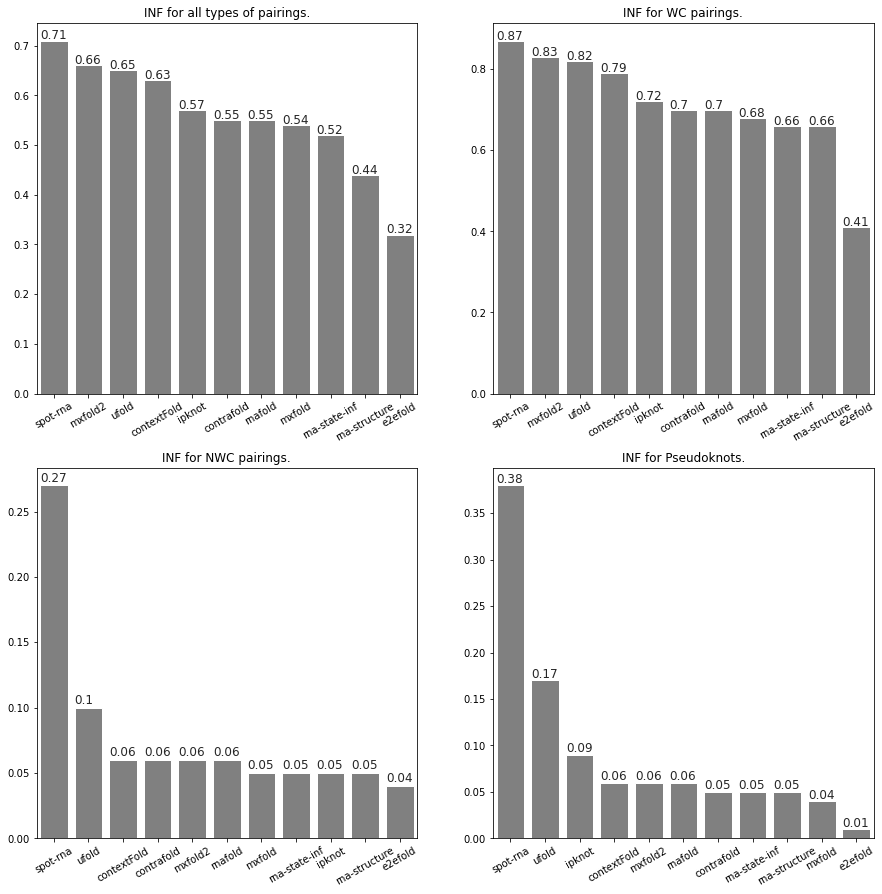

<Figure size 1080x504 with 0 Axes>

In [16]:
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
plt.figure(figsize=(15,7))
sns.set_theme(style="white")
# sns.set(rc={'figure.figsize':(20, 5)})
palette='Greys'

def barplot(df_means, axs, title:str):
    ax = sns.barplot(x=df_means.index, y="INF", color='grey', data=df_means, ax=axs)
    ax.set(title=title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    ax.set_ylabel("")
    for i, v in enumerate(df_means['INF']):
        ax.text(i-0.4, v+0.003, str(v))

barplot(all_dfmeans, axs[0][0], "INF for all types of pairings.")
barplot(wc_dfmeans, axs[0][1], "INF for WC pairings.")
barplot(nwc_dfmeans, axs[1][0], "INF for NWC pairings.")
barplot(pk_dfmeans, axs[1][1], "INF for Pseudoknots.")




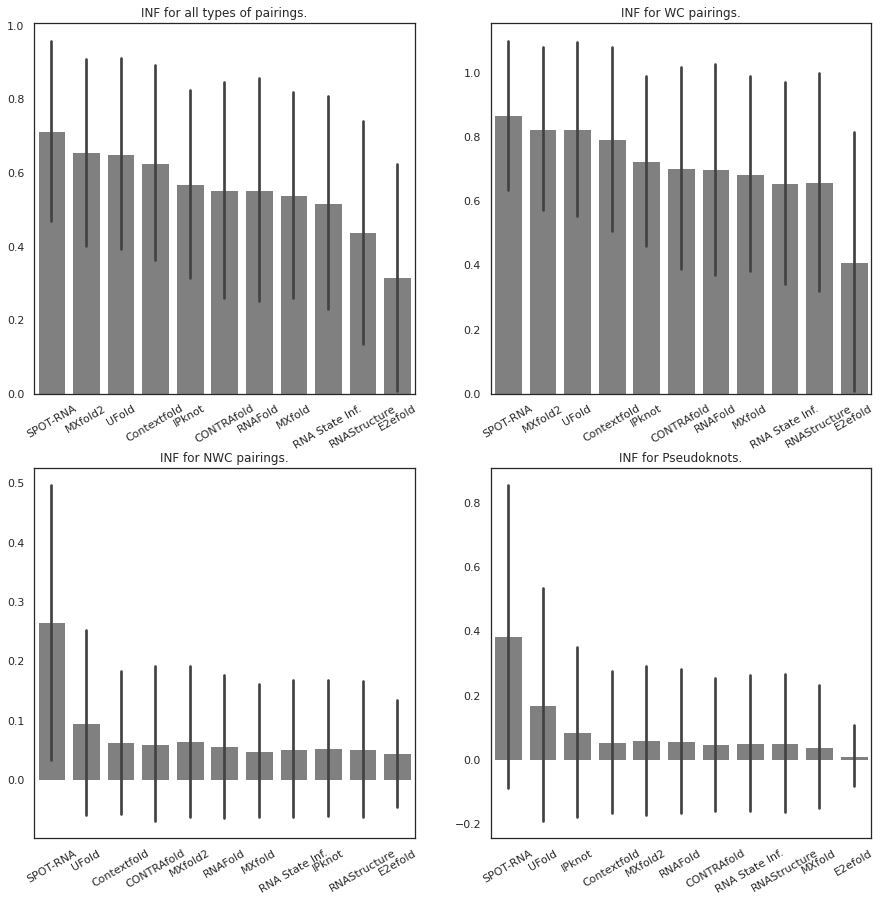

<Figure size 1080x504 with 0 Axes>

In [17]:

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
plt.figure(figsize=(15,7))
sns.set_theme(style="whitegrid")

palette='Greys'

def barplot_sd(sns_df, axs, title:str):
    ax = sns.barplot(x="Method", y="INF", color='grey', data=sns_df, ci='sd', ax=axs)
    ax.set(title=title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    ax.set_ylabel("")
    ax.set_xlabel("")

barplot_sd(all_sns, axs[0][0], "INF for all types of pairings.")
barplot_sd(wc_sns, axs[0][1], "INF for WC pairings.")
barplot_sd(nwc_sns, axs[1][0], "INF for NWC pairings.")
barplot_sd(pk_sns, axs[1][1], "INF for Pseudoknots.")


In [18]:
all_dfmeans['Method'] = all_dfmeans.index
print(len(all_dfmeans))
melt = pd.melt(all_dfmeans, id_vars='Method')
melt.head()

11


,Method,variable,value
0,spot-rna,PPV,0.61
1,mxfold2,PPV,0.54
2,ufold,PPV,0.53
3,contextFold,PPV,0.50
4,ipknot,PPV,0.46


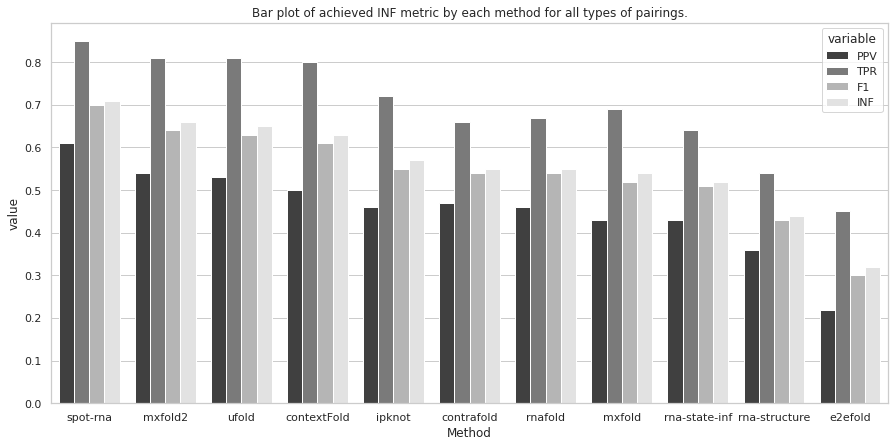

In [19]:
plt.figure(figsize=(15,7))
sns.set(rc={'figure.figsize':(10, 15)})
palette='Greys_r'
with sns.axes_style("whitegrid"):
    ax = sns.barplot(x='Method', y='value', hue='variable', palette = palette, data=melt)
    ax.set(title="Bar plot of achieved INF metric by each method for all types of pairings.")

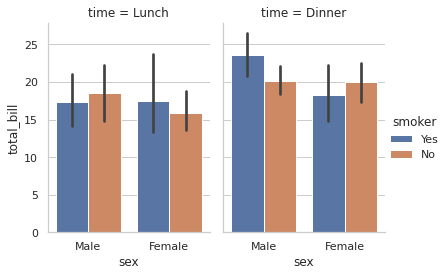

In [20]:
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
g = sns.catplot(x="sex", y="total_bill",
                hue="smoker", col="time",
                data=tips, kind="bar",
                height=4, aspect=.7);

### Seaborn boxplot of means

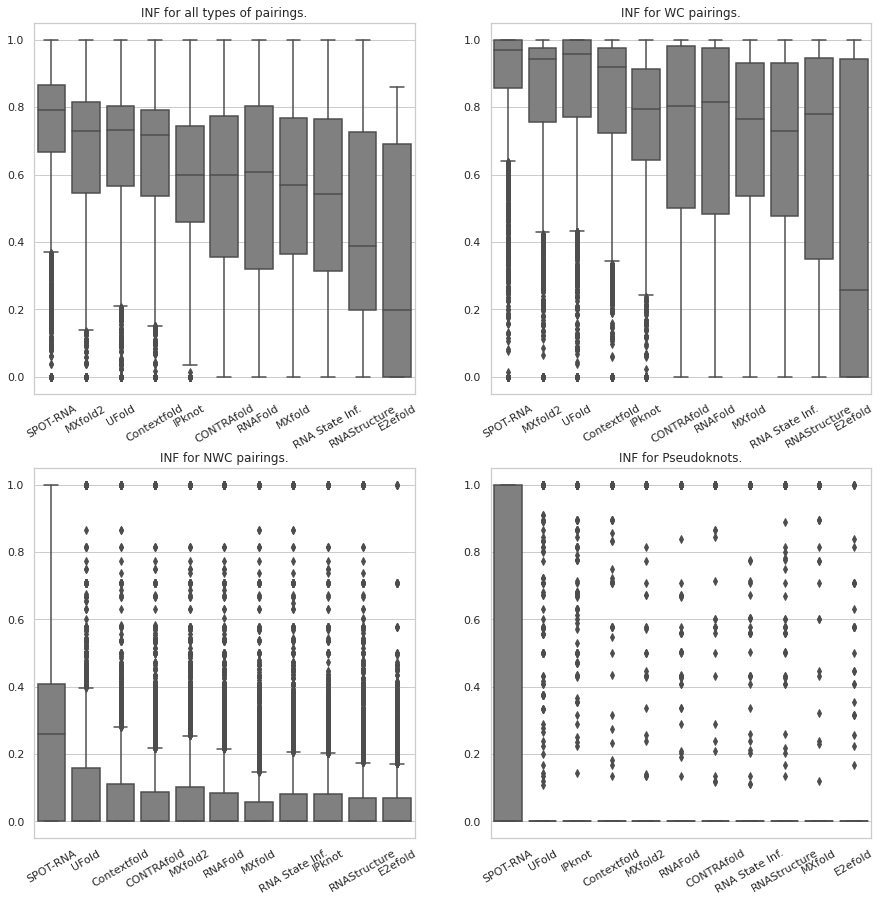

<Figure size 1080x504 with 0 Axes>

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
plt.figure(figsize=(15,7))
sns.set_theme(style="whitegrid")

palette='Greys'

def boxplot(sns_df, axs, title:str):
    ax = sns.boxplot(x="Method", y="INF", color='grey', data=sns_df, ax=axs)
    ax.set(title=title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    ax.set_ylabel("")
    ax.set_xlabel("")


boxplot(all_sns, axs[0][0], "INF for all types of pairings.")
boxplot(wc_sns, axs[0][1], "INF for WC pairings.")
boxplot(nwc_sns, axs[1][0], "INF for NWC pairings.")
boxplot(pk_sns, axs[1][1], "INF for Pseudoknots.")

## Seaborn violin plot

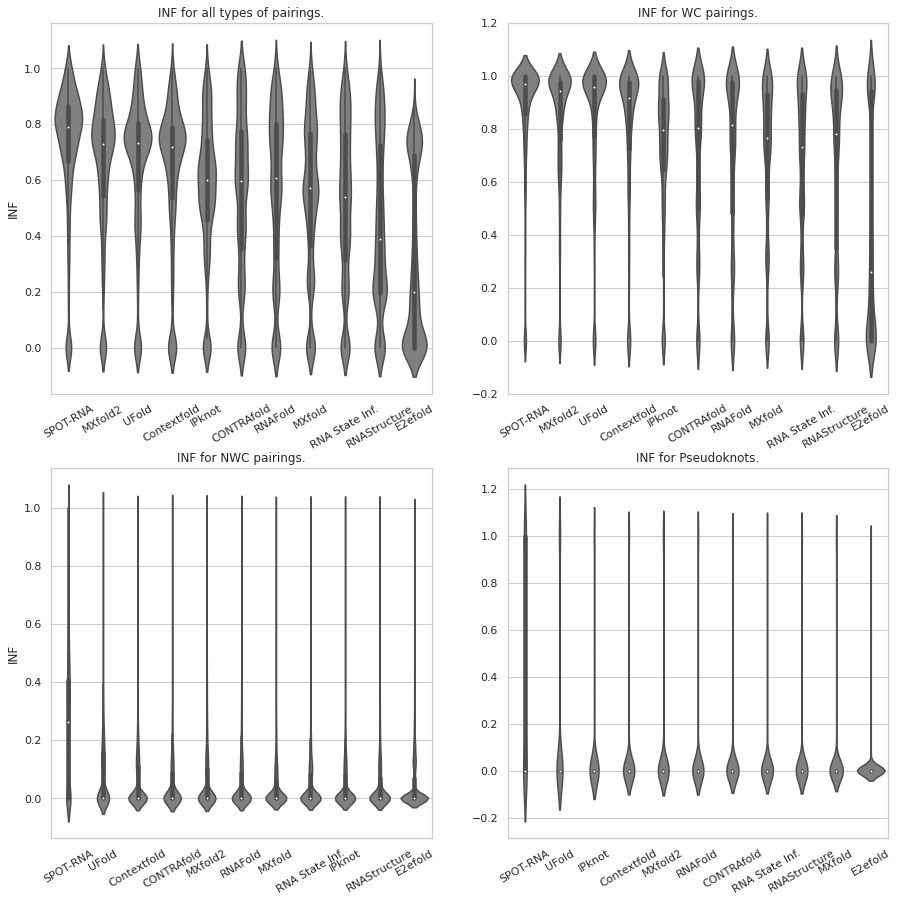

<Figure size 1080x504 with 0 Axes>

In [23]:
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
plt.figure(figsize=(15,7))
sns.set_theme(style="whitegrid")

def violinplot(sns_df, df_means, axs, title, y_left=True):
    ax = sns.violinplot(x='Method', y='INF', inner="box", color='grey', data=sns_df, ax=axs)
    ax.set(title=title)
    ax.set_xlabel("")
    if not y_left:
        ax.set_ylabel("")
        # ax.set_yticklabels("")
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)        
    # axR = ax.twinx() 
    # axR.yaxis.grid(False)#, linestyle='', which='major', color='grey', alpha=.25)
    # pos = np.arange(len(ax.get_yticks()))
    # axR.set_yticks(pos)
    # axR.set_yticklabels(df_means['INF'])
    # axR.set_ylim(ax.get_ylim())
    # axR.set_ylabel("Mean INF")


violinplot(all_sns, all_dfmeans, axs[0][0], "INF for all types of pairings.")
violinplot(wc_sns, wc_dfmeans, axs[0][1], "INF for WC pairings.", y_left=False)
violinplot(nwc_sns, nwc_dfmeans, axs[1][0], "INF for NWC pairings.")
violinplot(pk_sns, pk_dfmeans, axs[1][1], "INF for Pseudoknots.", y_left=False)

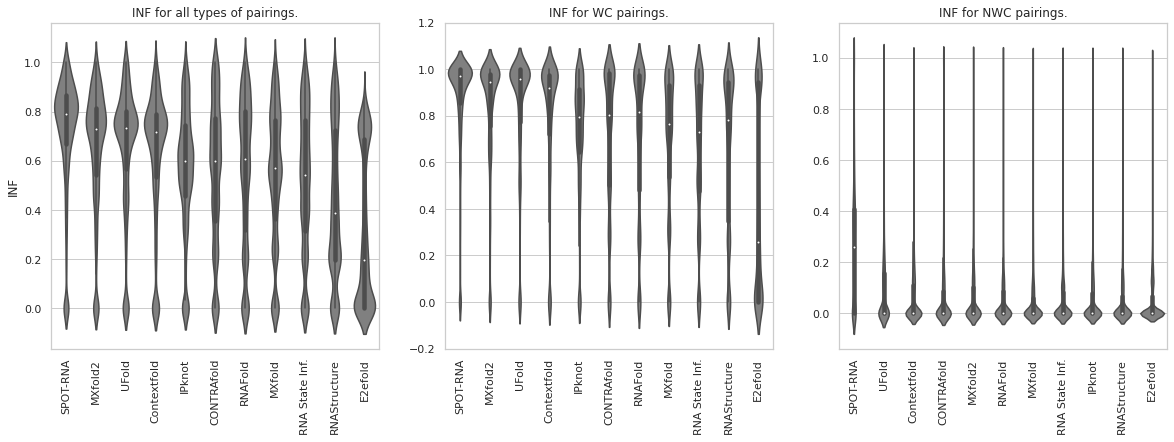

<Figure size 1080x504 with 0 Axes>

In [24]:
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
plt.figure(figsize=(15,7))
sns.set_theme(style="whitegrid")

def violinplot(sns_df, df_means, axs, title, y_left=True):
    ax = sns.violinplot(x='Method', y='INF', inner="box", color='grey', data=sns_df, ax=axs)
    ax.set(title=title)
    ax.set_xlabel("")
    if not y_left:
        ax.set_ylabel("")
        # ax.set_yticklabels("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)        
    # axR = ax.twinx() 
    # axR.yaxis.grid(False)#, linestyle='', which='major', color='grey', alpha=.25)
    # pos = np.arange(len(ax.get_yticks()))
    # axR.set_yticks(pos)
    # axR.set_yticklabels(df_means['INF'])
    # axR.set_ylim(ax.get_ylim())
    # axR.set_ylabel("Mean INF")


violinplot(all_sns, all_dfmeans, axs[0], "INF for all types of pairings.")
violinplot(wc_sns, wc_dfmeans, axs[1], "INF for WC pairings.", y_left=False)
violinplot(nwc_sns, nwc_dfmeans, axs[2], "INF for NWC pairings.", y_left=False)

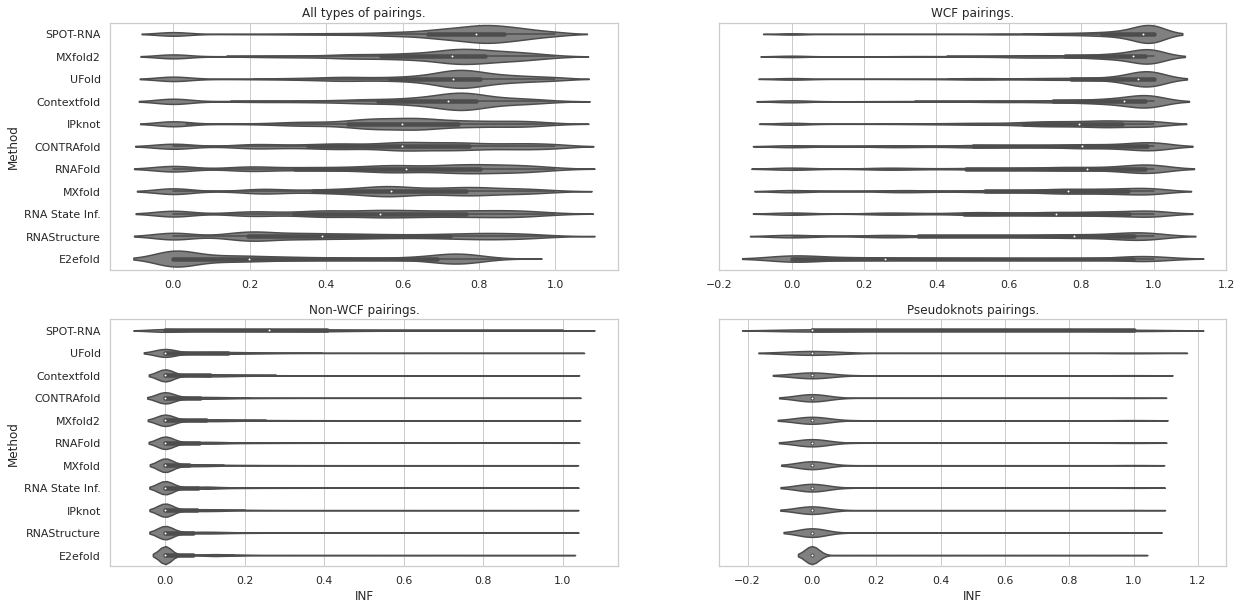

In [26]:
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
# plt.figure(figsize=(15,7))
sns.set_theme(style="whitegrid")

def violinplot(sns_df, df_means, axs, title, y_left=True, x_axis=True):
    ax = sns.violinplot(x='INF', y='Method', inner="box", color='grey', data=sns_df, ax=axs, cut=0)
    ax.set(title=title)
    # ax.set_xlabel("")
    if not y_left:
        ax.set_ylabel("")
        ax.set_yticklabels("")
    if not x_axis:
        ax.set_xlabel("")
    # ax.set_yticklabels(ax.get_yticklabels(), rotation = 30)        
    # axR = ax.twinx() 
    # axR.yaxis.grid(False)#, linestyle='', which='major', color='grey', alpha=.25)
    # pos = np.arange(len(ax.get_yticks()))
    # axR.set_yticks(pos)
    # axR.set_yticklabels(df_means['INF'])
    # axR.set_ylim(ax.get_ylim())
    # axR.set_ylabel("Mean INF")


violinplot(all_sns, all_dfmeans, axs[0][0], "All types of pairings.", x_axis=False)
violinplot(wc_sns, wc_dfmeans, axs[0][1], "WCF pairings.", y_left=False, x_axis=False)
violinplot(nwc_sns, nwc_dfmeans, axs[1][0], "Non-WCF pairings.", y_left=True)
violinplot(pk_sns, pk_dfmeans, axs[1][1], "Pseudoknots pairings.", y_left=False)